<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-7 </h1> </html>

<html> <h2 style="font-style:italic; color:blue;"> Transfer Learning </h2> </html>


<html> <h3 style="font-style:italic; color:blue;"> CIFAR10 Transfer Learning based Classifier </h3> </html>

<html> <h3 style="font-style:italic; color:blue;"> Inception-V3 </h3> </html>


##### This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN.
##### Particularly in this case based on Inception-V3


In [1]:
# For Google Colab only!

!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Unknown
IRQ:   		 11
GPU UUID: 	 GPU-a3598206-2754-2533-f92e-901c5d7f0963
Video BIOS: 	 90.04.a7.00.01
Bus Type: 	 PCI
DMA Size: 	 47 bits
DMA Mask: 	 0x7fffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
GPU Excluded:	 No


In [2]:
!pip install np_utils  # - need to run only one time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=9255955ad8ee9a3b4b6ee14c995ae0b6090737648957afb2d357344adbab873e
  Stored in directory: /root/.cache/pip/wheels/19/0d/33/eaa4dcda5799bcbb51733c0744970d10edb4b9add4f41beb43
Successfully built np_utils


In [3]:
pip install scipy==1.11.4    # - need to run only one time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [4]:
# import

import scipy as sp
import numpy as np
import pandas as pd

from numpy.random import rand
pd.options.display.max_colwidth = 600

In [5]:
# Scikit Imports

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split



In [9]:
# Use code in this cell for Google Colab only

# Run the cell twice and upload two filea (see the next 2 cells)
# cnn_utils.py      and
# /model_evaluation_utils.py

from google.colab import files
uploaded = files.upload()

Saving model_evaluation_utils.py to model_evaluation_utils.py


In [10]:
ls

cnn_utils.py  model_evaluation_utils.py  sample_data/


In [11]:
# Downloading the personal libraries

# Source the library here:
# https://github.com/JudasDie/deeplearning.ai/blob/master/Convolutional%20Neural%20Networks/week1/cnn_utils.py

import cnn_utils as utils

In [12]:
from scipy import interp

In [14]:
# Downloading the personal libraries

# Source the library here:
# https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/model_evaluation_utils.py


from model_evaluation_utils import get_metrics

In [15]:
# Matplot Imports

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

In [16]:
# pandas display data frames as tables

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [17]:
import tensorflow as tf
from tensorflow import keras

from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10


from keras import Model


from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [18]:
import np_utils

from keras.utils import to_categorical


### Load and manipulate the DataSet

In [19]:
BATCH_SIZE = 32
EPOCHS = 40
#EPOCHS = 15
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [20]:
# Download the dataset

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [27]:
# We reduce the size of print X_train, because otherwise we will not have enough memory!

X_train = X_train[:30000]
y_train = y_train[:30000]

In [28]:
print(X_train.shape)
print(y_train.shape)

(30000, 32, 32, 3)
(30000, 1)


In [29]:
# Split training dataset in train and validation sets:

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [30]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(25500, 1)
(4500, 1)
(10000, 1)


In [31]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.7Gi       4.7Gi       2.0Mi       6.2Gi        10Gi
Swap:             0B          0B          0B


In [32]:
# Transform target variable/labels into one hot encoded form

Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val   = to_categorical(y_val, NUM_CLASSES)
Y_test  = to_categorical(y_test, NUM_CLASSES)

In [33]:
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(25500, 10)
(4500, 10)
(10000, 10)


### Preprocessing

In [34]:
# Since we are about to use Inception-V3 as a feature extractor, the minimum size of an image it takes is 75x75.
# We utilize ```scipy`` to resize images to required dimensions


In [35]:
from skimage import transform

X_train = np.array([transform.resize(x,
                                     (75, 75)) for x in X_train])
X_val   = np.array([transform.resize(x,
                                     (75, 75)) for x in X_val])
X_test  = np.array([transform.resize(x,
                                     (75, 75)) for x in X_test])


In [36]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(25500, 75, 75, 3)
(4500, 75, 75, 3)
(10000, 75, 75, 3)


In [37]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       7.8Gi       392Mi       2.0Mi       4.5Gi       4.5Gi
Swap:             0B          0B          0B


### Create the Model

- Load Inception-V3 without the top classification layer
- Create a custom classifier
- Stack both models on top of each other


In [38]:
base_model = InceptionV3(weights='imagenet',
                       include_top=False,
                       #input_shape=(224, 224, 3),
                       input_shape=(75, 75, 3)
                      )

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 37, 37, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [40]:
# Extract the last layer from 7th block of InceptionV3 model

last = base_model.get_layer('mixed7').output


In [42]:
# Add classification layers on top of it

x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 37, 37, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 9,243,562 (35.26 MB)

 Trainable params: 9,223,210 (35.18 MB)

 Non-trainable params: 20,352 (79.50 KB)

In [44]:
# Since our objective is to only train the custom classifier,
# we freeze the layers of Inception-V3

for layer in base_model.layers:
     layer.trainable = False

In [45]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 37, 37, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 9,243,562 (35.26 MB)

 Trainable params: 266,762 (1.02 MB)

 Non-trainable params: 8,976,800 (34.24 MB)

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Data Augmentation



To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras  utilities


In [47]:
# create data augmentation configuration

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [48]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [49]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

### Train the Model

In [51]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.2391 - loss: 2.1110 - val_accuracy: 0.4382 - val_loss: 1.6520
Epoch 2/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3750 - loss: 1.9003 - val_accuracy: 0.4373 - val_loss: 1.6537
Epoch 3/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.4036 - loss: 1.6878 - val_accuracy: 0.4929 - val_loss: 1.4867
Epoch 4/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3750 - loss: 1.6327 - val_accuracy: 0.4922 - val_loss: 1.4865
Epoch 5/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4538 - loss: 1.5579 - val_accuracy: 0.5170 - val_loss: 1.4063
Epoch 6/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4375 - loss: 1.4635 - val_accuracy: 0.5183 - val_loss: 1.4054
Epoch 7/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.4857 - loss: 1.4719 - val_accuracy: 0.5324 - val_loss: 1.3491
Epoch 8/40
796/796 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3125 - loss: 1.6693 - val_accu

### Analyse Model Performance

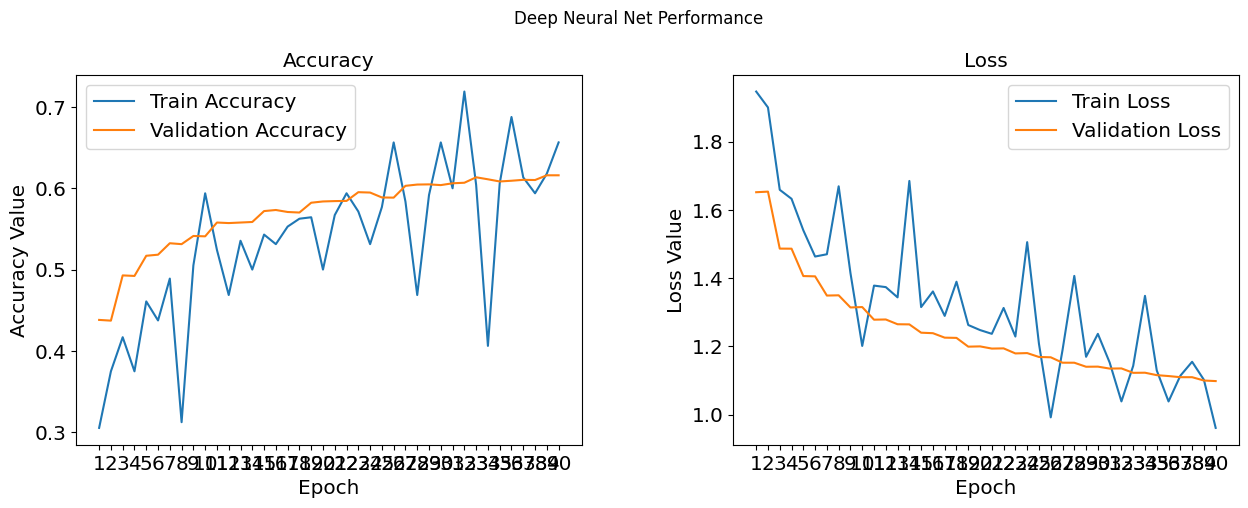

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [53]:
predictions = model.predict(X_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step


In [54]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [55]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.6201
Precision: 0.6176
Recall: 0.6201
F1 Score: 0.6177


In [57]:
from sklearn.metrics import classification_report

In [58]:
error_metrics_report = classification_report(y_test, predictions)
print(error_metrics_report)

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1000
           1       0.70      0.75      0.72      1000
           2       0.52      0.50      0.51      1000
           3       0.45      0.38      0.41      1000
           4       0.52      0.59      0.56      1000
           5       0.54      0.52      0.53      1000
           6       0.67      0.69      0.68      1000
           7       0.64      0.70      0.67      1000
           8       0.72      0.77      0.74      1000
           9       0.72      0.69      0.71      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [84]:
PretrainedModels = ['Inception-V3', 'VGG-16', 'VGG_19']

In [85]:
# Create lists for printing final results

ErrorMetrics = []
Accuracy = []
Precision = []
Recall = []
F1_Score = []

In [86]:
Accuracy.append(accuracy_score(y_test, predictions))
Precision.append(precision_score(y_test, predictions, average = 'macro'))
Recall.append(recall_score(y_test, predictions, average = 'macro'))
F1_Score.append(f1_score(y_test, predictions, average = 'macro'))

print(Accuracy, '\n', Precision, '\n', Recall, '\n', F1_Score)

[0.6201] 
 [0.617605889254186] 
 [0.6201000000000001] 
 [0.6176740970726261]


### Visualise Predictions

In [63]:
#label_dict = {0:'airplane',
#             1:'automobile',
#             2:'bird',
#             3:'cat',
#             4:'deer',
#             5:'dog',
#             6:'frog',
#             7:'horse',
#             8:'ship',
#             9:'truck'}

classes=['aircraft', 'car', 'bird', 'cat', 'deer',
 'dog', 'frog', 'hours', 'ship', 'truck']

In [64]:
# Graph this to look at the full set of 10 class predictions.


def plot_image(i,predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(label_dict[predicted_label],
                                    100 * np.max(predictions_array),
                                    label_dict[true_label]),
                                    color=color)

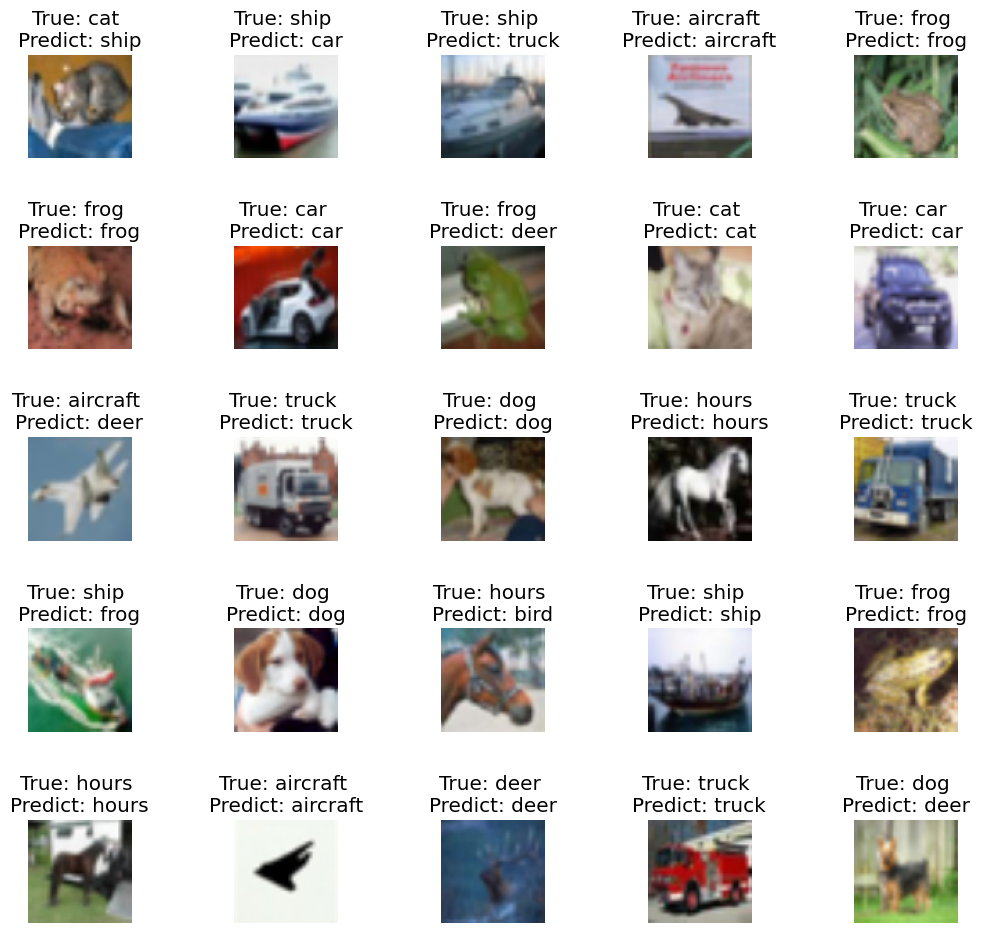

In [65]:
# Demonstration of the classifier prediction results

R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[np.argmax(Y_test[i])],
                                                  classes[predictions[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


# Comparison of results

Week-9_Transfer Learning_VGG-16-block3_Colab_ENG-RUR


Accuracy   : 0.655

Precision  : 0.6551154152560221

Recall     : 0.655

F1_Score   : 0.6539501197331854


In [87]:
# Week-9_Transfer Learning_VGG-16-block3_Colab_ENG-RUR

Accuracy.append(0.655)
Precision.append(0.6551154152560221)
Recall.append(0.655)
F1_Score.append(0.6539501197331854)


In [88]:
print(Accuracy, '\n', Precision, '\n', Recall, '\n', F1_Score)

[0.6201, 0.655] 
 [0.617605889254186, 0.6551154152560221] 
 [0.6201000000000001, 0.655] 
 [0.6176740970726261, 0.6539501197331854]


Week_9_Transfer_Learning_VGG_19_block5_Colab_ENG

Accuracy: 0.5008

Precision: 0.4927624651845129

Recall: 0.5007999999999999

F1 Score: 0.4950009603150436

In [89]:
# Week_9_Transfer_Learning_VGG_19_block5_Colab_ENG

Accuracy.append(0.5008)
Precision.append(0.4927624651845129)
Recall.append(0.5007999999999999)
F1_Score.append(0.4950009603150436)

In [90]:
print(Accuracy, '\n', Precision, '\n', Recall, '\n', F1_Score)

[0.6201, 0.655, 0.5008] 
 [0.617605889254186, 0.6551154152560221, 0.4927624651845129] 
 [0.6201000000000001, 0.655, 0.5007999999999999] 
 [0.6176740970726261, 0.6539501197331854, 0.4950009603150436]


In [91]:
ErrorMetrics.append(Accuracy)
ErrorMetrics.append(Precision)
ErrorMetrics.append(Recall)
ErrorMetrics.append(F1_Score)

In [92]:
ErrorMetrics

[[0.6201, 0.655, 0.5008],
 [0.617605889254186, 0.6551154152560221, 0.4927624651845129],
 [0.6201000000000001, 0.655, 0.5007999999999999],
 [0.6176740970726261, 0.6539501197331854, 0.4950009603150436]]

In [93]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd

,0,1,2
0,0.620100,0.655000,0.500800
1,0.617606,0.655115,0.492762
2,0.620100,0.655000,0.500800
3,0.617674,0.653950,0.495001


In [94]:
ErrorMetrics_pd.columns = PretrainedModels
ErrorMetrics_pd

,Inception-V3,VGG-16,VGG_19
0,0.620100,0.655000,0.500800
1,0.617606,0.655115,0.492762
2,0.620100,0.655000,0.500800
3,0.617674,0.653950,0.495001


In [95]:
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd

,0,1,2,3
Inception-V3,0.6201,0.617606,0.6201,0.617674
VGG-16,0.6550,0.655115,0.6550,0.653950
VGG_19,0.5008,0.492762,0.5008,0.495001


In [96]:
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

,Accuracy,Precision,Recall,F1_Score
Inception-V3,0.6201,0.617606,0.6201,0.617674
VGG-16,0.6550,0.655115,0.6550,0.653950
VGG_19,0.5008,0.492762,0.5008,0.495001


<Axes: >

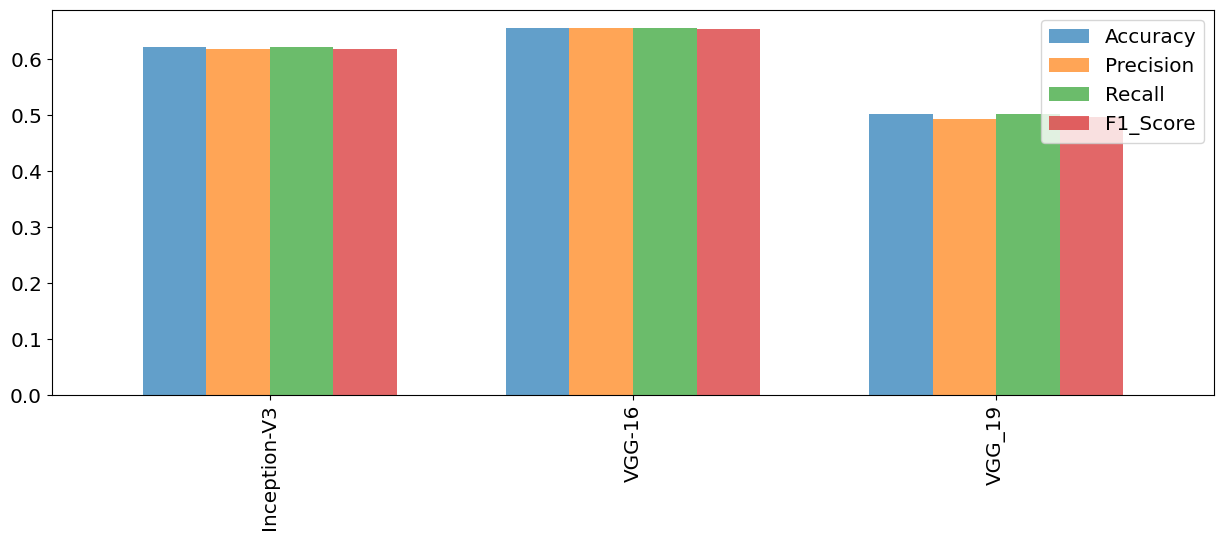

In [97]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)